## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've defined the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(40, 80, kernel_size=(2, 2), stride=(1, 1))
  (drop_conv): Dropout(p=0.1)
  (drop_fc): Dropout(p=0.2)
  (fc1): Linear(in_features=2000, out_features=544, bias=True)
  (fc2): Linear(in_features=544, out_features=272, bias=True)
  (fc3): Linear(in_features=272, out_features=136, bias=True)
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5):

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

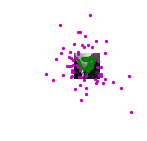

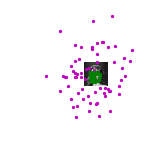

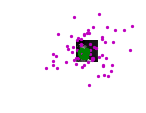

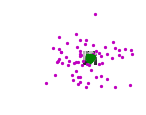

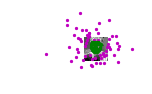

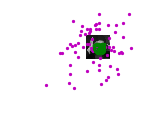

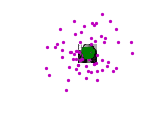

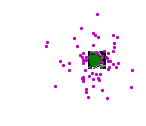

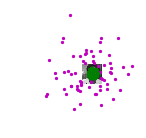

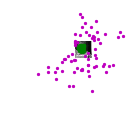

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](https://pytorch.org/docs/master/nn.html#loss-functions).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.2e-3)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.023398343324661255
Epoch: 1, Batch: 20, Avg. Loss: 0.020166675209999086
Epoch: 1, Batch: 30, Avg. Loss: 0.018233287811279298
Epoch: 1, Batch: 40, Avg. Loss: 0.016896393179893495
Epoch: 1, Batch: 50, Avg. Loss: 0.015864753484725953
Epoch: 1, Batch: 60, Avg. Loss: 0.014467603325843811
Epoch: 1, Batch: 70, Avg. Loss: 0.013709012508392335
Epoch: 1, Batch: 80, Avg. Loss: 0.01241357958316803
Epoch: 1, Batch: 90, Avg. Loss: 0.011806426525115966
Epoch: 1, Batch: 100, Avg. Loss: 0.011170419156551361
Epoch: 1, Batch: 110, Avg. Loss: 0.010276481091976165
Epoch: 1, Batch: 120, Avg. Loss: 0.01052196478843689
Epoch: 1, Batch: 130, Avg. Loss: 0.009557453095912933
Epoch: 1, Batch: 140, Avg. Loss: 0.009221641540527344
Epoch: 1, Batch: 150, Avg. Loss: 0.008591232359409333
Epoch: 1, Batch: 160, Avg. Loss: 0.008632298946380615
Epoch: 1, Batch: 170, Avg. Loss: 0.007627807021141052
Epoch: 1, Batch: 180, Avg. Loss: 0.0074877293109893795
Epoch: 1, Batch: 190, Avg. Loss: 0.006

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.0045850473940372465
Epoch: 2, Batch: 20, Avg. Loss: 0.004450611174106598
Epoch: 2, Batch: 30, Avg. Loss: 0.004288413286209106
Epoch: 2, Batch: 40, Avg. Loss: 0.004151926040649414
Epoch: 2, Batch: 50, Avg. Loss: 0.004127889633178711
Epoch: 2, Batch: 60, Avg. Loss: 0.003959773898124695
Epoch: 2, Batch: 70, Avg. Loss: 0.004022937595844269
Epoch: 2, Batch: 80, Avg. Loss: 0.0038945105969905853
Epoch: 2, Batch: 90, Avg. Loss: 0.003595942586660385
Epoch: 2, Batch: 100, Avg. Loss: 0.003735375732183456
Epoch: 2, Batch: 110, Avg. Loss: 0.0037137480080127717
Epoch: 2, Batch: 120, Avg. Loss: 0.0036663621962070465
Epoch: 2, Batch: 130, Avg. Loss: 0.003553543299436569
Epoch: 2, Batch: 140, Avg. Loss: 0.003409984618425369
Epoch: 2, Batch: 150, Avg. Loss: 0.003513148844242096
Epoch: 2, Batch: 160, Avg. Loss: 0.003397788554430008
Epoch: 2, Batch: 170, Avg. Loss: 0.003314331293106079
Epoch: 2, Batch: 180, Avg. Loss: 0.0030843514800071715
Epoch: 2, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.0024406982362270356
Epoch: 3, Batch: 20, Avg. Loss: 0.0026093660593032838
Epoch: 3, Batch: 30, Avg. Loss: 0.0024086177945137023
Epoch: 3, Batch: 40, Avg. Loss: 0.002581875056028366
Epoch: 3, Batch: 50, Avg. Loss: 0.0023711020946502685
Epoch: 3, Batch: 60, Avg. Loss: 0.0023594841063022615
Epoch: 3, Batch: 70, Avg. Loss: 0.002382813945412636
Epoch: 3, Batch: 80, Avg. Loss: 0.0022574144452810288
Epoch: 3, Batch: 90, Avg. Loss: 0.0024901095181703568
Epoch: 3, Batch: 100, Avg. Loss: 0.002272967308759689
Epoch: 3, Batch: 110, Avg. Loss: 0.0022994183152914047
Epoch: 3, Batch: 120, Avg. Loss: 0.0023704583644866945
Epoch: 3, Batch: 130, Avg. Loss: 0.0022068046629428865
Epoch: 3, Batch: 140, Avg. Loss: 0.0023021917194128035
Epoch: 3, Batch: 150, Avg. Loss: 0.0022649129778146743
Epoch: 3, Batch: 160, Avg. Loss: 0.002121157631278038
Epoch: 3, Batch: 170, Avg. Loss: 0.0022285630106925964
Epoch: 3, Batch: 180, Avg. Loss: 0.0021405940502882003
Epoch: 3, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0016680336743593216
Epoch: 4, Batch: 20, Avg. Loss: 0.0017617558538913726
Epoch: 4, Batch: 30, Avg. Loss: 0.001774543285369873
Epoch: 4, Batch: 40, Avg. Loss: 0.0019480464160442352
Epoch: 4, Batch: 50, Avg. Loss: 0.001674995720386505
Epoch: 4, Batch: 60, Avg. Loss: 0.001954715445637703
Epoch: 4, Batch: 70, Avg. Loss: 0.0018195112347602843
Epoch: 4, Batch: 80, Avg. Loss: 0.0017455327063798905
Epoch: 4, Batch: 90, Avg. Loss: 0.0016490382254123687
Epoch: 4, Batch: 100, Avg. Loss: 0.001679160937666893
Epoch: 4, Batch: 110, Avg. Loss: 0.0017538056522607803
Epoch: 4, Batch: 120, Avg. Loss: 0.0016630577892065047
Epoch: 4, Batch: 130, Avg. Loss: 0.0017201714068651199
Epoch: 4, Batch: 140, Avg. Loss: 0.0016499827578663826
Epoch: 4, Batch: 150, Avg. Loss: 0.0014965110421180725
Epoch: 4, Batch: 160, Avg. Loss: 0.0015886424407362937
Epoch: 4, Batch: 170, Avg. Loss: 0.0014944227039813995
Epoch: 4, Batch: 180, Avg. Loss: 0.0016702140495181083
Epoch: 4, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0014343803599476813
Epoch: 5, Batch: 20, Avg. Loss: 0.0013543039411306381
Epoch: 5, Batch: 30, Avg. Loss: 0.0014579998180270196
Epoch: 5, Batch: 40, Avg. Loss: 0.0015976303666830063
Epoch: 5, Batch: 50, Avg. Loss: 0.0017321852296590804
Epoch: 5, Batch: 60, Avg. Loss: 0.0014517286941409112
Epoch: 5, Batch: 70, Avg. Loss: 0.0014009937644004823
Epoch: 5, Batch: 80, Avg. Loss: 0.0014665338695049287
Epoch: 5, Batch: 90, Avg. Loss: 0.0012637293115258217
Epoch: 5, Batch: 100, Avg. Loss: 0.0013555223420262336
Epoch: 5, Batch: 110, Avg. Loss: 0.0013737338855862617
Epoch: 5, Batch: 120, Avg. Loss: 0.0013598212003707885
Epoch: 5, Batch: 130, Avg. Loss: 0.0012504898458719253
Epoch: 5, Batch: 140, Avg. Loss: 0.0012284639552235604
Epoch: 5, Batch: 150, Avg. Loss: 0.001355740524828434
Epoch: 5, Batch: 160, Avg. Loss: 0.0013505154699087142
Epoch: 5, Batch: 170, Avg. Loss: 0.0012581792101264
Epoch: 5, Batch: 180, Avg. Loss: 0.0012873343527317047
Epoch: 5, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0010927416533231735
Epoch: 6, Batch: 20, Avg. Loss: 0.0012447509989142419
Epoch: 6, Batch: 30, Avg. Loss: 0.0011470894291996955
Epoch: 6, Batch: 40, Avg. Loss: 0.001184196725487709
Epoch: 6, Batch: 50, Avg. Loss: 0.0012731709182262421
Epoch: 6, Batch: 60, Avg. Loss: 0.0011972209066152572
Epoch: 6, Batch: 70, Avg. Loss: 0.0014215915575623512
Epoch: 6, Batch: 80, Avg. Loss: 0.0011551562696695329
Epoch: 6, Batch: 90, Avg. Loss: 0.0012284458577632904
Epoch: 6, Batch: 100, Avg. Loss: 0.0011729508116841317
Epoch: 6, Batch: 110, Avg. Loss: 0.001130888655781746
Epoch: 6, Batch: 120, Avg. Loss: 0.0013578836396336556
Epoch: 6, Batch: 130, Avg. Loss: 0.0010774789005517959
Epoch: 6, Batch: 140, Avg. Loss: 0.0009826154112815857
Epoch: 6, Batch: 150, Avg. Loss: 0.001012215442955494
Epoch: 6, Batch: 160, Avg. Loss: 0.001243709310889244
Epoch: 6, Batch: 170, Avg. Loss: 0.001147572748363018
Epoch: 6, Batch: 180, Avg. Loss: 0.0012668386772274971
Epoch: 6, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.00131541159003973
Epoch: 7, Batch: 20, Avg. Loss: 0.0009640747681260109
Epoch: 7, Batch: 30, Avg. Loss: 0.0010430682450532913
Epoch: 7, Batch: 40, Avg. Loss: 0.0011026755124330522
Epoch: 7, Batch: 50, Avg. Loss: 0.0011710131615400314
Epoch: 7, Batch: 60, Avg. Loss: 0.0008853890672326088
Epoch: 7, Batch: 70, Avg. Loss: 0.0009976171627640725
Epoch: 7, Batch: 80, Avg. Loss: 0.0010435640662908555
Epoch: 7, Batch: 90, Avg. Loss: 0.0010327546782791614
Epoch: 7, Batch: 100, Avg. Loss: 0.00094305270165205
Epoch: 7, Batch: 110, Avg. Loss: 0.0010531852394342423
Epoch: 7, Batch: 120, Avg. Loss: 0.0009078428000211716
Epoch: 7, Batch: 130, Avg. Loss: 0.0008561715334653854
Epoch: 7, Batch: 140, Avg. Loss: 0.001050131104886532
Epoch: 7, Batch: 150, Avg. Loss: 0.0009505856148898602
Epoch: 7, Batch: 160, Avg. Loss: 0.0010184124559164047
Epoch: 7, Batch: 170, Avg. Loss: 0.0009023227542638779
Epoch: 7, Batch: 180, Avg. Loss: 0.0009396801441907882
Epoch: 7, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.0008861873224377632
Epoch: 8, Batch: 20, Avg. Loss: 0.0009514976590871811
Epoch: 8, Batch: 30, Avg. Loss: 0.0008306537345051765
Epoch: 8, Batch: 40, Avg. Loss: 0.0010795806050300598
Epoch: 8, Batch: 50, Avg. Loss: 0.0010854402221739292
Epoch: 8, Batch: 60, Avg. Loss: 0.0008781404010951519
Epoch: 8, Batch: 70, Avg. Loss: 0.0007689247988164425
Epoch: 8, Batch: 80, Avg. Loss: 0.0008483505509793758
Epoch: 8, Batch: 90, Avg. Loss: 0.0007582696601748466
Epoch: 8, Batch: 100, Avg. Loss: 0.0007691330313682556
Epoch: 8, Batch: 110, Avg. Loss: 0.0007613573409616947
Epoch: 8, Batch: 120, Avg. Loss: 0.0007562419474124909
Epoch: 8, Batch: 130, Avg. Loss: 0.0008374497331678867
Epoch: 8, Batch: 140, Avg. Loss: 0.0007706501446664333
Epoch: 8, Batch: 150, Avg. Loss: 0.0008326751217246056
Epoch: 8, Batch: 160, Avg. Loss: 0.0010211710780858993
Epoch: 8, Batch: 170, Avg. Loss: 0.0007294379360973835
Epoch: 8, Batch: 180, Avg. Loss: 0.0008141694627702236
Epoch: 8, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.0009175208695232868
Epoch: 9, Batch: 20, Avg. Loss: 0.0006808641441166401
Epoch: 9, Batch: 30, Avg. Loss: 0.0007117094732820988
Epoch: 9, Batch: 40, Avg. Loss: 0.0010136707797646523
Epoch: 9, Batch: 50, Avg. Loss: 0.0008733374737203121
Epoch: 9, Batch: 60, Avg. Loss: 0.0007426759637892246
Epoch: 9, Batch: 70, Avg. Loss: 0.0006910144314169884
Epoch: 9, Batch: 80, Avg. Loss: 0.0008539684638381004
Epoch: 9, Batch: 90, Avg. Loss: 0.0006603789813816547
Epoch: 9, Batch: 100, Avg. Loss: 0.0006977508068084717
Epoch: 9, Batch: 110, Avg. Loss: 0.0008282957375049591
Epoch: 9, Batch: 120, Avg. Loss: 0.0006464247405529022
Epoch: 9, Batch: 130, Avg. Loss: 0.0009417127035558224
Epoch: 9, Batch: 140, Avg. Loss: 0.0007573793195188045
Epoch: 9, Batch: 150, Avg. Loss: 0.0007028439268469811
Epoch: 9, Batch: 160, Avg. Loss: 0.0005901836827397346
Epoch: 9, Batch: 170, Avg. Loss: 0.0007300578132271767
Epoch: 9, Batch: 180, Avg. Loss: 0.0006937974281609058
Epoch: 9, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.000650713961571455
Epoch: 10, Batch: 20, Avg. Loss: 0.0005448167026042938
Epoch: 10, Batch: 30, Avg. Loss: 0.0007117747813463211
Epoch: 10, Batch: 40, Avg. Loss: 0.0007075388059020043
Epoch: 10, Batch: 50, Avg. Loss: 0.0006675781756639481
Epoch: 10, Batch: 60, Avg. Loss: 0.000560539074242115
Epoch: 10, Batch: 70, Avg. Loss: 0.000631091833114624
Epoch: 10, Batch: 80, Avg. Loss: 0.0006108195297420025
Epoch: 10, Batch: 90, Avg. Loss: 0.0005888599213212728
Epoch: 10, Batch: 100, Avg. Loss: 0.0005798247158527374
Epoch: 10, Batch: 110, Avg. Loss: 0.000618273925036192
Epoch: 10, Batch: 120, Avg. Loss: 0.000705084040760994
Epoch: 10, Batch: 130, Avg. Loss: 0.0006983205191791057
Epoch: 10, Batch: 140, Avg. Loss: 0.0006834754571318626
Epoch: 10, Batch: 150, Avg. Loss: 0.0005256888568401336
Epoch: 10, Batch: 160, Avg. Loss: 0.00094221206381917
Epoch: 10, Batch: 170, Avg. Loss: 0.000733518011868
Epoch: 10, Batch: 180, Avg. Loss: 0.0008039829917252064
Epoch: 10, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.0006338772997260093
Epoch: 11, Batch: 20, Avg. Loss: 0.0006625680476427078
Epoch: 11, Batch: 30, Avg. Loss: 0.0005611982084810734
Epoch: 11, Batch: 40, Avg. Loss: 0.0007312320321798324
Epoch: 11, Batch: 50, Avg. Loss: 0.0005901907645165921
Epoch: 11, Batch: 60, Avg. Loss: 0.0008118260018527508
Epoch: 11, Batch: 70, Avg. Loss: 0.0006963419653475284
Epoch: 11, Batch: 80, Avg. Loss: 0.0005938415229320526
Epoch: 11, Batch: 90, Avg. Loss: 0.0006720825806260109
Epoch: 11, Batch: 100, Avg. Loss: 0.0006857154630124569
Epoch: 11, Batch: 110, Avg. Loss: 0.0006685481444001198
Epoch: 11, Batch: 120, Avg. Loss: 0.0007773476801812649
Epoch: 11, Batch: 130, Avg. Loss: 0.0007494420483708382
Epoch: 11, Batch: 140, Avg. Loss: 0.0005314472839236259
Epoch: 11, Batch: 150, Avg. Loss: 0.00068543815985322
Epoch: 11, Batch: 160, Avg. Loss: 0.0005788901038467884
Epoch: 11, Batch: 170, Avg. Loss: 0.0006671999543905259
Epoch: 11, Batch: 180, Avg. Loss: 0.0005988693386316299
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.00054370753839612
Epoch: 12, Batch: 20, Avg. Loss: 0.0005789423398673535
Epoch: 12, Batch: 30, Avg. Loss: 0.0006335666608065367
Epoch: 12, Batch: 40, Avg. Loss: 0.0005098695568740368
Epoch: 12, Batch: 50, Avg. Loss: 0.0005579568222165108
Epoch: 12, Batch: 60, Avg. Loss: 0.00046482588909566404
Epoch: 12, Batch: 70, Avg. Loss: 0.0006997715458273888
Epoch: 12, Batch: 80, Avg. Loss: 0.0005675962716341019
Epoch: 12, Batch: 90, Avg. Loss: 0.0005186476949602365
Epoch: 12, Batch: 100, Avg. Loss: 0.0006865501403808594
Epoch: 12, Batch: 110, Avg. Loss: 0.0005736887827515602
Epoch: 12, Batch: 120, Avg. Loss: 0.0004935602452605963
Epoch: 12, Batch: 130, Avg. Loss: 0.0006322792209684849
Epoch: 12, Batch: 140, Avg. Loss: 0.0006160478573292494
Epoch: 12, Batch: 150, Avg. Loss: 0.0004970442708581686
Epoch: 12, Batch: 160, Avg. Loss: 0.00046280852705240247
Epoch: 12, Batch: 170, Avg. Loss: 0.0004632162470370531
Epoch: 12, Batch: 180, Avg. Loss: 0.0006255949139595032
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.00044640054740011694
Epoch: 13, Batch: 20, Avg. Loss: 0.0005208563655614853
Epoch: 13, Batch: 30, Avg. Loss: 0.0007432168163359165
Epoch: 13, Batch: 40, Avg. Loss: 0.0006582562066614628
Epoch: 13, Batch: 50, Avg. Loss: 0.0007507735900580883
Epoch: 13, Batch: 60, Avg. Loss: 0.0005832755118608475
Epoch: 13, Batch: 70, Avg. Loss: 0.0004576464630663395
Epoch: 13, Batch: 80, Avg. Loss: 0.0006152791529893875
Epoch: 13, Batch: 90, Avg. Loss: 0.00048786480911076067
Epoch: 13, Batch: 100, Avg. Loss: 0.0005724979247897864
Epoch: 13, Batch: 110, Avg. Loss: 0.0007259882893413305
Epoch: 13, Batch: 120, Avg. Loss: 0.0005715166423469782
Epoch: 13, Batch: 130, Avg. Loss: 0.0005071277655661106
Epoch: 13, Batch: 140, Avg. Loss: 0.0005248300321400166
Epoch: 13, Batch: 150, Avg. Loss: 0.00042901059240102766
Epoch: 13, Batch: 160, Avg. Loss: 0.0005296616666018963
Epoch: 13, Batch: 170, Avg. Loss: 0.0005002980623394251
Epoch: 13, Batch: 180, Avg. Loss: 0.000509822983294725

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.00042353831604123116
Epoch: 14, Batch: 20, Avg. Loss: 0.0007300863228738308
Epoch: 14, Batch: 30, Avg. Loss: 0.0005938429236412049
Epoch: 14, Batch: 40, Avg. Loss: 0.0006490848250687122
Epoch: 14, Batch: 50, Avg. Loss: 0.0005933850165456534
Epoch: 14, Batch: 60, Avg. Loss: 0.00046744083613157274
Epoch: 14, Batch: 70, Avg. Loss: 0.0005062632858753204
Epoch: 14, Batch: 80, Avg. Loss: 0.0005996064431965351
Epoch: 14, Batch: 90, Avg. Loss: 0.0006524444930255413
Epoch: 14, Batch: 100, Avg. Loss: 0.0004724510349333286
Epoch: 14, Batch: 110, Avg. Loss: 0.00046878594532608986
Epoch: 14, Batch: 120, Avg. Loss: 0.00046505690552294253
Epoch: 14, Batch: 130, Avg. Loss: 0.0005164207890629768
Epoch: 14, Batch: 140, Avg. Loss: 0.0004916086718440056
Epoch: 14, Batch: 150, Avg. Loss: 0.0005418782886117697
Epoch: 14, Batch: 160, Avg. Loss: 0.0004817683659493923
Epoch: 14, Batch: 170, Avg. Loss: 0.0005883723609149456
Epoch: 14, Batch: 180, Avg. Loss: 0.00055566504038870

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.00045653850585222245
Epoch: 15, Batch: 20, Avg. Loss: 0.0004545366317033768
Epoch: 15, Batch: 30, Avg. Loss: 0.0005257031209766864
Epoch: 15, Batch: 40, Avg. Loss: 0.0006739550065249204
Epoch: 15, Batch: 50, Avg. Loss: 0.0005202207304537297
Epoch: 15, Batch: 60, Avg. Loss: 0.0005162485036998987
Epoch: 15, Batch: 70, Avg. Loss: 0.0005049937926232815
Epoch: 15, Batch: 80, Avg. Loss: 0.000599756421521306
Epoch: 15, Batch: 90, Avg. Loss: 0.00039728446677327154
Epoch: 15, Batch: 100, Avg. Loss: 0.00044499575532972813
Epoch: 15, Batch: 110, Avg. Loss: 0.00044506664387881754
Epoch: 15, Batch: 120, Avg. Loss: 0.0006314928103238344
Epoch: 15, Batch: 130, Avg. Loss: 0.0004207667000591755
Epoch: 15, Batch: 140, Avg. Loss: 0.0003954425770789385
Epoch: 15, Batch: 150, Avg. Loss: 0.0005738321077078581
Epoch: 15, Batch: 160, Avg. Loss: 0.0005626132227480412
Epoch: 15, Batch: 170, Avg. Loss: 0.0003970940504223108
Epoch: 15, Batch: 180, Avg. Loss: 0.000410225933417677

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


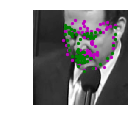

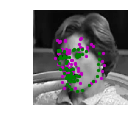

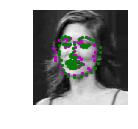

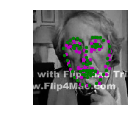

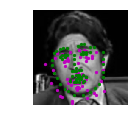

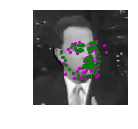

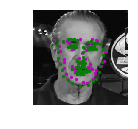

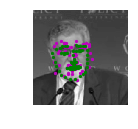

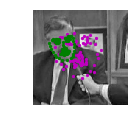

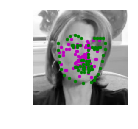

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [17]:
## TODO: change the name to something unique for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

Loss Funtion: SMOOTHL1LOSS (Creates a criterion that uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise). I chose this for simplicity over a 2D data array.

Optimization Method: ADAM . It proved to have a good performance over the set... and it is the StateOfTheArt optim method.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

I have chosen different architectures to end up in a three step convolutional network followed by a a three step MLP similar to the NAIMISHNET shown in documentation. It proved to give poor results and improved the model through documentation given in the course to find the model architecture chosen.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:
I tested the network and saw the loss performance over time. I realized the Loss decreased since the very beginning and it was not necessary to have so many epochs to get a convergence point from 15 epochs... nonetheless, I sticked to 30 epochs since the model had already been trained.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.00312369 -0.01814627 -0.05681593  0.04937546  0.08700795]
 [ 0.03023607 -0.03330594  0.10147266  0.04227847 -0.06531883]
 [ 0.01043835 -0.09381784 -0.06374779 -0.0073992  -0.06382996]
 [-0.05220017  0.0361882  -0.10197982  0.09413698 -0.05670946]
 [ 0.02129212  0.07883746  0.06612643  0.00626391 -0.08445416]]
(5, 5)


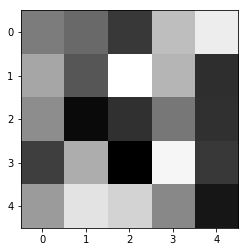

In [18]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

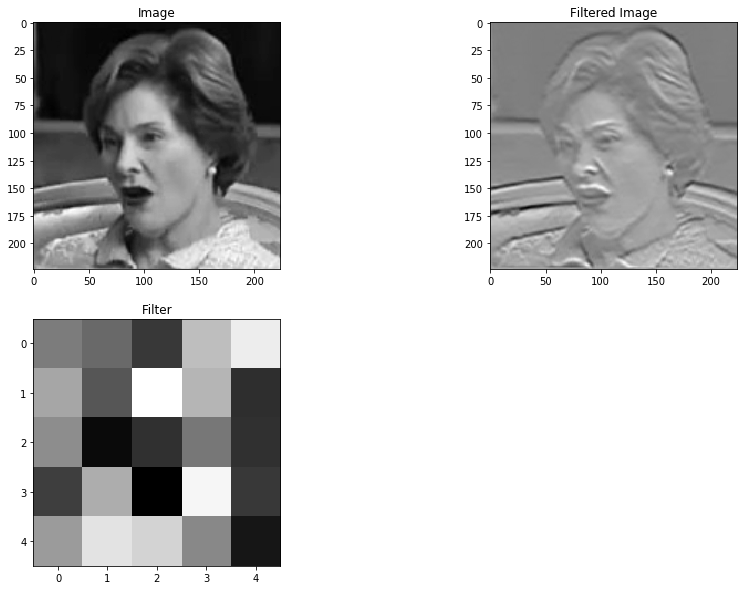

In [19]:
##TODO: load in and display any image from the transformed test dataset

import cv2

idx = 1

image = test_images[idx].data
image = image.numpy()
image = np.squeeze(np.transpose(image, (1, 2, 0)))
weights1 = net.conv1.weight.data
w = weights1.numpy()

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

filtered = cv2.filter2D(image, -1, w[idx][0])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax.imshow(image, cmap = 'gray')
ax.set_title("Image")
ax = fig.add_subplot(222)
ax.imshow(filtered, cmap = 'gray')
ax.set_title("Filtered Image")
ax = fig.add_subplot(223)
ax.imshow(w[filter_index][0], cmap = 'gray')
ax.set_title("Filter")
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:
It detects in the face features like where eyes, nose, mouth and contour of the face are within the image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!